# **FASHION-PRODUCTS RECOMMENDATION SYSTEM** 



In [ ]:
!pip install -q kaggle
from google.colab import drive
drive.mount('/content/drive')
from google.colab import files
files.upload()

Mounted at /content/drive


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"pranjalsubhash","key":"21dcf581a3715963e0083c2bda952bf4"}'}

In [ ]:
import gc 
gc.collect()


146

In [ ]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [ ]:
!chmod 600 /root/.kaggle/kaggle.json

In [ ]:
! kaggle datasets download -d paramaggarwal/fashion-product-images-dataset

100% 23.1G/23.1G [06:40<00:00, 52.8MB/s]
100% 23.1G/23.1G [06:40<00:00, 61.9MB/s]


In [ ]:
! mkdir dataset
!unzip fashion-product-images-dataset.zip -d dataset

Streaming output truncated to the last 5000 lines.
  inflating: dataset/fashion-dataset/styles/58128.json  
  inflating: dataset/fashion-dataset/styles/58129.json  
  inflating: dataset/fashion-dataset/styles/5813.json  
  inflating: dataset/fashion-dataset/styles/58131.json  
  inflating: dataset/fashion-dataset/styles/58132.json  
  inflating: dataset/fashion-dataset/styles/58133.json  
  inflating: dataset/fashion-dataset/styles/58135.json  
  inflating: dataset/fashion-dataset/styles/58136.json  
  inflating: dataset/fashion-dataset/styles/58137.json  
  inflating: dataset/fashion-dataset/styles/58138.json  
  inflating: dataset/fashion-dataset/styles/58139.json  
  inflating: dataset/fashion-dataset/styles/5814.json  
  inflating: dataset/fashion-dataset/styles/58140.json  
  inflating: dataset/fashion-dataset/styles/58141.json  
  inflating: dataset/fashion-dataset/styles/58143.json  
  inflating: dataset/fashion-dataset/styles/58144.json  
  inflating: dataset/fashion-dataset/st

In [ ]:
import numpy as np
import pandas as pd
import os 
import tensorflow as tf
import tensorflow.keras as keras
from keras import Model
from keras.applications import DenseNet121
from keras.applications import vgg16
from keras.preprocessing import image
from keras.applications.densenet import preprocess_input, decode_predictions
from keras.layers import GlobalMaxPooling2D
from keras.utils import plot_model
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
import pathlib
from sklearn.metrics.pairwise import linear_kernel

In [ ]:
path = '/content/dataset/fashion-dataset/fashion-dataset/'
dataset_path = pathlib.Path(path)
images=os.listdir(dataset_path)
images

['styles.csv', 'styles', 'images.csv', 'images']

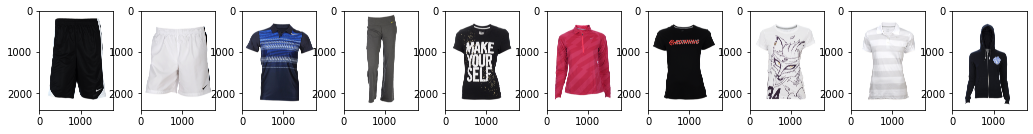

In [ ]:
plt.figure(figsize=(20,20))
for i in range(20,30):
    plt.subplot(6, 10, i-10+1)
    cloth_img =  mpimg.imread(path + 'images/100'+ str(i) +'.jpg')
    plt.imshow(cloth_img)
plt.subplots_adjust(wspace=-0.5, hspace=1)
plt.show()

In [ ]:
df = pd.read_csv(path + "styles.csv",nrows=6000,error_bad_lines=False)
df['image'] = df.apply(lambda x: str(x['id']) + ".jpg", axis=1)
print(df.shape)
df.head(5)

(6000, 11)


,id,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage,productDisplayName,image
0,15970,Men,Apparel,Topwear,Shirts,Navy Blue,Fall,2011,Casual,Turtle Check Men Navy Blue Shirt,15970.jpg
1,39386,Men,Apparel,Bottomwear,Jeans,Blue,Summer,2012,Casual,Peter England Men Party Blue Jeans,39386.jpg
2,59263,Women,Accessories,Watches,Watches,Silver,Winter,2016,Casual,Titan Women Silver Watch,59263.jpg
3,21379,Men,Apparel,Bottomwear,Track Pants,Black,Fall,2011,Casual,Manchester United Men Solid Black Track Pants,21379.jpg
4,53759,Men,Apparel,Topwear,Tshirts,Grey,Summer,2012,Casual,Puma Men Grey T-shirt,53759.jpg


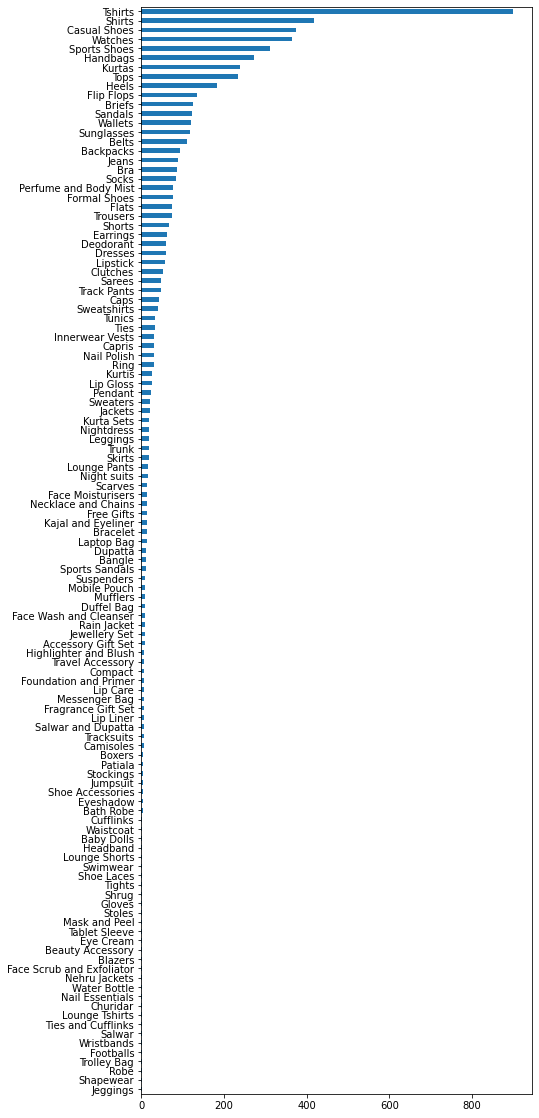

In [ ]:
plt.figure(figsize=(7,20))
df.articleType.value_counts().sort_values().plot(kind='barh')

In [ ]:
img_width, img_height, chnl = 200, 200, 3

In [ ]:
#VGG16
from tensorflow.keras.applications import VGG16
vgg=VGG16(include_top=False,weights='imagenet',input_shape=(img_width, img_height, chnl))
vgg.trainable=False
model1 = keras.Sequential([vgg,GlobalMaxPooling2D()])
model1.summary()

58892288/58889256 [==============================] - 1s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 6, 6, 512)         14714688  
_________________________________________________________________
global_max_pooling2d (Global (None, 512)               0         
Total params: 14,714,688
Trainable params: 0
Non-trainable params: 14,714,688
_________________________________________________________________


In [ ]:
#DenseNet121
densenet = DenseNet121(include_top=False, weights='imagenet', input_shape=(img_width, img_height, chnl))
densenet.trainable = False

model2 = keras.Sequential([densenet,GlobalMaxPooling2D()])

model2.summary()

29089792/29084464 [==============================] - 0s 0us/step
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet121 (Functional)     (None, 6, 6, 1024)        7037504   
_________________________________________________________________
global_max_pooling2d_1 (Glob (None, 1024)              0         
Total params: 7,037,504
Trainable params: 0
Non-trainable params: 7,037,504
_________________________________________________________________


In [ ]:
#Resnet50
from keras.applications.resnet50 import ResNet50
resnet = ResNet50(weights='imagenet', include_top=False, input_shape = (img_width, img_height, chnl))
resnet.trainable = False
model3 = keras.Sequential([resnet,GlobalMaxPooling2D()])

model3.summary()

94773248/94765736 [==============================] - 1s 0us/step
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 7, 7, 2048)        23587712  
_________________________________________________________________
global_max_pooling2d_2 (Glob (None, 2048)              0         
Total params: 23,587,712
Trainable params: 0
Non-trainable params: 23,587,712
_________________________________________________________________


In [ ]:
def img_path(img):
    return path + 'images/' + img
def model_predict(model, img_name):
    # Reshape
    img = image.load_img(img_path(img_name), target_size=(img_width, img_height))
    # img to Array
    x   = image.img_to_array(img)
    # Expand Dim (1, w, h)
    x   = np.expand_dims(x, axis=0)
    # Pre process Input
    x   = preprocess_input(x)
    return model.predict(x).reshape(-1)

In [ ]:
df_copy1      = df
df_embedding1 = df_copy1['image'].apply(lambda x: model_predict(model1, x))
df_embedding1 = df_embedding1.apply(pd.Series)
df_embedding1.head(5)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,472,473,474,475,476,477,478,479,480,481,482,483,484,485,486,487,488,489,490,491,492,493,494,495,496,497,498,499,500,501,502,503,504,505,506,507,508,509,510,511
0,0.000000,0.0,0.000000,0.00000,0.969926,0.000000,0.264032,0.850382,1.365396,1.185080,1.155226,0.000000,1.260077,0.0,0.000000,1.475152,0.000000,0.825597,0.0,2.415044,0.267700,0.000000,0.720231,4.389048,0.947912,0.000000,0.897255,1.740898,0.901777,0.000000,0.535456,0.915541,0.696601,0.442635,0.992095,0.0,0.231428,1.612456,0.0,0.326235,...,0.000000,0.445025,2.679123,0.000000,0.000000,0.000000,0.000000,0.186623,2.080053,0.000000,0.875658,0.444444,1.123783,1.036173,1.364932,0.756833,0.487582,0.010997,0.000000,0.453380,0.159142,0.000000,1.638549,1.071191,0.000000,0.000000,1.444359,1.735440,1.069768,0.995781,1.658546,4.763140,1.017862,1.009776,3.129323,0.639458,0.000000,0.843652,0.516443,1.698475
1,0.720978,0.0,0.928663,0.00000,0.888794,0.045286,0.613651,1.970467,0.000000,0.000000,1.304192,0.000000,1.077299,0.0,0.441370,1.114781,0.864610,0.811626,0.0,3.435133,0.000000,1.591859,2.353407,2.431896,0.125879,0.000000,0.410935,2.696096,0.000000,0.000000,0.447363,1.900274,0.812599,0.608379,0.591476,0.0,0.417221,1.773211,0.0,0.000000,...,2.113590,1.444057,2.298748,1.442821,1.490735,0.384280,0.250753,0.341026,1.300977,0.300673,0.411979,0.490879,0.000000,0.039248,1.521019,0.172255,0.000000,0.844763,1.628561,1.787001,0.000000,0.239845,1.376378,1.714810,0.908421,0.317089,1.484498,3.960718,1.344764,0.505690,1.325968,5.357210,0.647488,1.597262,4.027083,0.431153,1.461777,1.721223,0.862622,1.088421
2,2.528080,0.0,1.713117,3.03993,0.458621,0.292367,0.000000,0.000000,0.000000,1.810554,1.733101,0.000000,2.699543,0.0,0.207283,1.261149,0.000000,0.469867,0.0,0.002708,0.180010,0.000000,0.642922,2.949684,0.905700,0.000000,3.130543,2.219194,0.000000,0.375441,1.035589,0.071637,0.923344,0.802057,0.933191,0.0,0.409205,5.942202,0.0,2.144457,...,0.337660,1.059739,2.254169,0.016059,5.989273,0.000000,0.000000,0.171343,0.024506,0.000000,1.704566,0.885539,0.000000,0.993389,1.112035,0.489102,0.086208,0.250337,0.000000,0.657495,2.892081,0.000000,1.023332,0.842523,0.000000,0.000000,0.399386,3.963411,1.059864,0.113331,1.658494,0.187787,1.833699,0.000000,0.000000,0.869788,0.000000,0.234692,1.204082,0.130292
3,0.036455,0.0,0.253100,0.00000,1.709379,0.614108,0.649377,0.042372,0.000000,0.000000,0.929796,0.182021,0.868297,0.0,0.000000,1.524999,0.259656,0.668703,0.0,4.290099,0.089697,0.960722,1.458580,2.420243,0.000000,0.000000,0.480645,0.000000,0.467113,0.381299,1.213685,2.051783,1.153514,1.099784,0.387346,0.0,0.467557,1.043277,0.0,0.000000,...,1.860874,2.110570,3.181820,0.659418,0.102697,0.613211,0.000000,0.318237,1.984785,0.000000,0.330448,0.815371,1.329327,0.000000,1.357509,0.868685,0.702081,1.679825,0.566506,1.456385,0.000000,0.000000,1.329127,0.970962,0.924506,0.474080,0.966521,1.995747,1.306304,0.000000,2.113817,5.409175,0.442773,0.006580,3.405471,0.463958,0.715300,0.741315,0.657128,1.376887
4,0.000000,0.0,0.420788,0.00000,0.742421,0.000000,0.000000,0.000000,0.526171,0.000000,2.149643,2.458698,2.826772,0.0,0.000000,0.101985,0.000000,0.434349,0.0,1.990378,0.338834,1.151094,0.193450,6.349531,0.230629,0.033555,0.141857,0.000000,0.590465,0.000000,0.511067,0.830708,0.898840,0.252917,0.748604,0.0,0.397050,0.835288,0.0,0.000000,...,1.305116,0.000000,2.365270,0.000000,0.000000,0.414982,0.000000,0.000000,1.890221,0.000000,0.539253,1.340224,1.529257,1.286267,0.644760,0.004766,0.000000,0.119955,0.000000,0.843589,0.023022,0.381800,1.082314,0.261630,0.287825,0.091776,0.949792,2.583257,1.776302,0.015375,1.730401,2.952892,0.689063,0.000000,1.201562,0.566411,0.000000,0.113429,0.531207,0.406624


In [ ]:
df_copy2      = df
df_embedding2 = df_copy2['image'].apply(lambda x: model_predict(model2, x))
df_embedding2 = df_embedding2.apply(pd.Series)
df_embedding2.head(5)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,984,985,986,987,988,989,990,991,992,993,994,995,996,997,998,999,1000,1001,1002,1003,1004,1005,1006,1007,1008,1009,1010,1011,1012,1013,1014,1015,1016,1017,1018,1019,1020,1021,1022,1023
0,0.002788,0.012018,0.015049,0.018872,0.243038,1.575965,0.001352,0.012589,0.930550,0.001562,0.018930,0.059341,0.005751,0.189636,0.085153,0.000875,0.003500,1.403339,0.009358,0.001758,0.013695,0.039081,0.002569,0.017502,0.008260,0.009707,0.012586,0.086211,0.024189,0.011434,0.018092,0.020212,0.099100,0.001203,1.121352,0.010900,0.023673,0.086993,0.003600,0.189577,...,2.444988,2.153108,1.098477,0.000000,1.234522,1.364079,0.196254,1.050624,0.214955,0.819496,0.053639,5.169407,0.301983,9.783775,1.930043,6.484999,1.125860,1.208890,1.876980,2.041674,1.569337,8.549067,2.395504,2.765847,0.885202,0.411332,8.339241,0.020884,3.768932,2.460952,0.865118,0.041214,5.479110,0.058247,0.111022,2.994077,3.067470,3.911140,8.003329,4.090550
1,0.000938,0.010240,0.014157,0.033368,0.232703,1.341560,0.001307,0.014866,0.515353,0.001125,0.006806,0.055998,0.005011,0.174345,0.077652,0.001081,0.002332,2.161611,0.011678,0.003473,0.010206,0.028889,0.001639,0.002270,0.018056,0.009452,0.008636,0.068102,0.020629,0.007827,0.050846,0.016810,0.120669,0.002001,1.377191,0.006419,0.015550,0.069266,0.010744,0.094974,...,0.852898,1.254182,0.332090,0.000000,0.701979,1.613119,0.896858,0.000000,0.938394,0.000000,2.726426,6.254345,1.646044,1.865404,3.563105,0.000000,0.942224,1.504678,1.363946,0.025234,2.043824,3.567573,0.000000,4.791038,3.506275,0.807757,3.505484,0.000000,10.395720,0.517748,2.026179,2.503708,11.056705,1.638572,0.518402,2.941536,0.941135,1.342542,1.992480,1.315468
2,0.001214,0.013573,0.015378,0.007322,0.364703,1.351420,0.002805,0.005552,0.648474,0.001928,0.012080,0.070956,0.004140,0.142932,0.086556,0.000847,0.006349,2.775115,0.006703,0.001360,0.009930,0.023171,0.001691,0.002043,0.011233,0.007166,0.004554,0.062083,0.014861,0.005886,0.063313,0.013815,0.088600,0.002467,1.732166,0.007727,0.024900,0.066056,0.016484,0.267535,...,2.866175,6.276756,1.125575,10.101522,7.594793,0.554644,0.000000,0.101951,3.075699,2.446904,3.096616,2.425942,1.839580,5.269170,2.703022,0.542977,2.672443,1.180465,0.844143,1.388158,4.618525,0.882598,0.581842,0.417542,2.365218,0.357591,6.416884,0.807459,2.158741,9.650938,4.141378,1.066640,1.784389,4.047666,3.761928,1.472842,1.410462,6.991835,9.101624,0.933299
3,0.001080,0.014465,0.022208,0.018075,0.293791,4.160222,0.001272,0.012537,0.477517,0.002318,0.009964,0.036610,0.004496,0.119279,0.107572,0.000737,0.002602,1.617550,0.010541,0.002741,0.010286,0.019638,0.001764,0.001785,0.017537,0.007846,0.004869,0.070911,0.018993,0.018038,0.053620,0.013856,0.182232,0.002248,1.069942,0.006100,0.014544,0.144814,0.004418,0.084623,...,1.098617,1.241152,0.669356,1.415731,1.066701,1.891637,1.683406,0.629922,0.738079,0.684179,1.939831,8.555999,1.006239,2.939267,2.376226,0.000000,1.432217,0.894433,0.979971,1.567473,6.759212,2.696587,0.931480,3.642912,3.633167,1.178263,3.142149,0.563092,7.406689,0.573726,1.129939,0.632331,10.668557,2.681414,0.326609,3.301012,0.000000,2.327763,5.492822,0.780043
4,0.001774,0.011407,0.012123,0.018447,0.337456,1.672158,0.001197,0.011453,0.505674,0.000860,0.010486,0.050516,0.001675,0.191297,0.077079,0.000898,0.002597,1.681407,0.013542,0.002832,0.012983,0.022312,0.002789,0.015115,0.013338,0.007478,0.008589,0.105872,0.025671,0.012513,0.038475,0.020667,0.214350,0.002059,0.332966,0.008567,0.024376,0.116681,0.005635,0.094925,...,3.735529,1.536468,0.734439,0.850383,2.249449,2.901268,0.000000,0.000000,0.232050,0.110687,3.762285,7.062905,3.268998,3.258754,0.000000,3.445889,0.000000,1.681139,4.229860,4.045993,3.766426,3.324150,0.815953,13.575412,7.578600,3.569378,6.198618,0.458299,7.462382,2.580548,0.718572,2.938368,10.829136,0.801260,1.382702,2.993904,1.796370,10.143234,7.059011,1.023522


In [ ]:
df_copy3     = df
df_embedding3 = df_copy3['image'].apply(lambda x: model_predict(model3, x))
df_embedding3 = df_embedding3.apply(pd.Series)
df_embedding3.head(5)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023,2024,2025,2026,2027,2028,2029,2030,2031,2032,2033,2034,2035,2036,2037,2038,2039,2040,2041,2042,2043,2044,2045,2046,2047
0,0.000000,4.244417,0.682927,1.965715,3.793344,0.0,2.193495,0.00000,2.682626,0.0,1.432620,0.0,0.000000,1.190039,3.822911,2.832691,0.000000,1.236089,3.123703,0.608153,0.651892,4.566151,4.285017,1.186466,3.986224,0.000000,4.546152,0.115740,0.0,0.000000,2.025257,1.924952,0.000000,14.604861,1.332487,1.186188,0.0,0.000000,6.180320,1.353302,...,2.422909,0.000000,2.493861,1.957360,0.000000,2.464932,0.000000,0.927974,0.000000,0.000000,0.000000,0.0,0.978787,3.854814,3.573552,1.002512,0.008570,2.505416,0.000000,0.000000,0.0,1.970585,1.133855,0.000000,2.294496,5.591516,0.0,0.000000,0.819967,3.084444,1.342998,0.000000,0.828574,13.758913,0.858622,6.180054,0.000000,10.628553,2.733934,0.909958
1,0.000000,4.329235,1.215337,3.502513,2.434253,0.0,1.921607,0.00000,3.107435,0.0,1.528769,0.0,0.000000,0.000000,15.339857,0.487606,0.538677,0.905239,0.000000,0.000000,0.000000,3.430915,2.801386,3.468270,0.075525,0.000000,3.898611,0.000000,0.0,1.400618,0.000000,0.000000,0.097978,0.000000,1.253531,1.126604,0.0,1.003770,5.384223,0.000000,...,0.000000,0.000000,0.000000,0.000000,1.182682,0.000000,0.286888,0.000000,0.510097,1.537410,1.448321,0.0,0.320394,1.954945,3.748140,0.194827,0.000000,2.133534,0.670877,0.000000,0.0,0.000000,0.000000,0.000000,0.886789,4.324301,0.0,0.000000,0.000000,0.000000,0.096800,0.000000,2.492510,0.000000,0.000000,2.089953,0.000000,9.805559,5.345196,0.000000
2,0.000000,3.419519,0.000000,3.428656,3.201848,0.0,3.379972,0.00000,1.286799,0.0,0.302348,0.0,0.000000,0.000000,1.606190,0.000000,0.019580,1.373522,0.000000,1.408816,0.000000,2.779584,1.771293,0.549823,0.691041,0.000000,5.553818,0.000000,0.0,1.992641,0.424095,0.000000,0.560770,2.147345,0.000000,3.316272,0.0,0.162357,6.179563,0.582551,...,5.296588,0.000000,0.000000,1.956733,0.000000,0.279809,0.438548,0.000000,0.000000,8.574173,0.313014,0.0,3.113808,0.000000,4.626155,0.000000,0.000000,0.000000,1.020497,0.000000,0.0,0.361224,0.000000,1.255955,0.000000,0.858962,0.0,0.000000,0.000000,1.406896,0.492611,0.000000,0.000000,0.000000,0.021129,0.000000,0.000000,9.260536,3.664966,0.000000
3,0.261428,1.529949,0.000000,5.815762,5.521102,0.0,1.954223,0.40983,3.613780,0.0,0.596094,0.0,0.013469,0.000000,5.798158,2.718244,0.246501,0.000000,0.298076,1.036896,0.000000,3.506041,5.266198,2.256635,0.292429,0.342703,4.454811,0.000000,0.0,2.458192,2.025932,0.000000,0.725522,0.000000,0.490026,0.846313,0.0,2.658541,3.278955,0.777362,...,1.141615,1.090553,0.000000,0.000000,2.865138,0.000000,0.409005,0.000000,0.000000,1.098922,2.312577,0.0,0.371915,1.687286,3.063465,0.593920,0.000000,2.611681,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.570191,1.235280,0.0,0.049763,0.000000,0.000000,1.585915,0.783188,1.165574,0.000000,0.000000,2.244051,0.281268,9.020486,7.094460,2.101193
4,0.000000,2.907169,0.060927,2.630498,0.511857,0.0,3.261317,0.00000,1.869537,0.0,2.411734,0.0,0.359605,0.000000,6.814919,0.606189,0.199532,0.625705,2.353791,0.000000,0.000000,4.532259,4.443134,1.229937,0.384989,0.000000,3.960582,0.565295,0.0,0.000000,4.078341,0.944818,0.000000,10.850953,0.039108,2.465959,0.0,0.000000,10.754391,1.026464,...,3.844733,0.000000,0.910095,0.000000,2.501039,0.655571,0.889160,0.000000,0.000000,0.907387,0.000000,0.0,0.974827,4.021152,3.737926,3.906057,0.471332,0.959539,1.160317,0.186199,0.0,0.000000,0.000000,0.272483,1.198914,3.417125,0.0,0.000000,0.000000,1.630194,3.060236,0.000000,0.886876,6.685858,0.425247,1.527207,0.000000,9.584128,7.988427,1.055583


In [ ]:
print(df_embedding1.shape) #VGG16
print(df_embedding2.shape) #Densenet121
print(df_embedding3.shape) #Resnet50

(6000, 512)
(6000, 1024)
(6000, 2048)


In [ ]:
url="/content/s1.jpg"

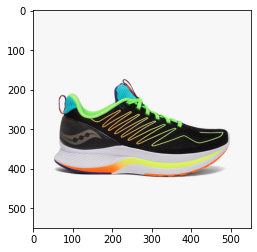

In [ ]:
a = plt.imread(url)
plt.imshow(a)

In [ ]:
def model_predict(model, url):
     # Reshape
     img = image.load_img(url, target_size=(img_width, img_height))
     # img to Array
     x   = image.img_to_array(img)
     # Expand Dim (1, w, h)
     x   = np.expand_dims(x, axis=0)
     # Pre process Input
     x   = preprocess_input(x)
     return model.predict(x)

In [ ]:
df_vgg=model_predict(model1, url)
df_dn=model_predict(model2, url)
df_rn=model_predict(model3, url)

In [ ]:
print(df_vgg)
print(df_vgg.shape)
print(df_dn)
print(df_dn.shape)
print(df_rn)
print(df_rn.shape)

   0         1         2         3    ...       508  509       510       511
0  0.0  0.012184  0.460468  0.580198  ...  0.499325  0.0  0.992093  0.122846

[1 rows x 512 columns]
(1, 512)
       0         1         2     ...      1021     1022      1023
0  0.000958  0.012212  0.005194  ...  1.660696  4.56169  1.529435

[1 rows x 1024 columns]
(1, 1024)
   0         1     2         3     ...  2044      2045      2046  2047
0   0.0  1.018147   0.0  0.128939  ...   0.0  8.571083  1.334185   0.0

[1 rows x 2048 columns]
(1, 2048)


In [ ]:
df_vgg = pd.DataFrame(df_vgg)  
print(df_vgg)
df_dn = pd.DataFrame(df_dn)  
print(df_dn)
df_rn = pd.DataFrame(df_rn)  
print(df_rn)

   0         1         2         3    ...       508  509       510       511
0  0.0  0.012184  0.460468  0.580198  ...  0.499325  0.0  0.992093  0.122846

[1 rows x 512 columns]
       0         1         2     ...      1021     1022      1023
0  0.000958  0.012212  0.005194  ...  1.660696  4.56169  1.529435

[1 rows x 1024 columns]
   0         1     2         3     ...  2044      2045      2046  2047
0   0.0  1.018147   0.0  0.128939  ...   0.0  8.571083  1.334185   0.0

[1 rows x 2048 columns]


In [ ]:
cosine_sim1 = linear_kernel(df_vgg, df_embedding1)
print(cosine_sim1[0])
cosine_sim2 = linear_kernel(df_dn, df_embedding2)
print(cosine_sim2[0])
cosine_sim3 = linear_kernel(df_rn, df_embedding3)
print(cosine_sim3[0])

[543.50494 558.6108  611.072   ... 943.0526  658.0917  763.0944 ]
[ 4980.737   5107.3125  6968.472  ... 13556.576   5952.336   5065.9517]
[13981.162 12570.513 13714.943 ... 16163.186 14206.206 16332.788]


In [ ]:
def range_cs(cosine_sim):
  x_min=cosine_sim.min(axis=1)
  x_max=cosine_sim.max(axis=1)
  norm=(cosine_sim-x_min)/(x_max-x_min)[:, np.newaxis]
  return norm

In [ ]:
vgg_norm=range_cs(cosine_sim1)
dn_norm=range_cs(cosine_sim2)
rn_norm=range_cs(cosine_sim3)

In [ ]:
def get_recommendations(x, df, cosine_sim):
    #idx = indices[index]

    # Get the pairwsie similarity scores of all clothes with that one
    sim_scores = list(enumerate(cosine_sim[x]))
    
    # Sort the clothes based on the similarity scores
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    
    # Get the scores of the 5 most similar clothes
    sim_scores = sim_scores[0:5]
    print(sim_scores)
    # Get the clothes indices
    cloth_indices = [i[0] for i in sim_scores]

    # Return the top 5 most similar products
    return df['image'].iloc[cloth_indices]

[(3656, 1.0), (2848, 0.97617984), (4886, 0.9639322), (2290, 0.9613268), (45, 0.9533779)]


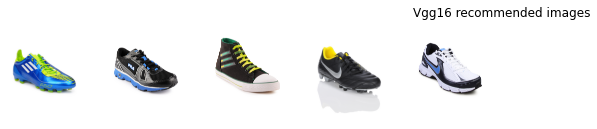

[(3591, 1.0), (2874, 0.9981175), (859, 0.98181605), (1084, 0.9708067), (5296, 0.962925)]


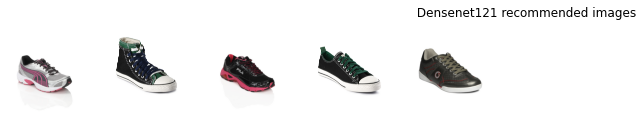

[(1373, 1.0), (2727, 0.97989696), (1302, 0.9619575), (5296, 0.9564023), (4432, 0.9479745)]


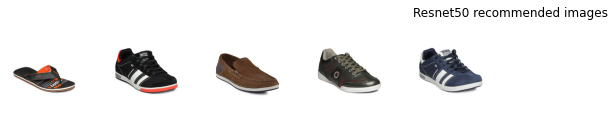

In [ ]:
chosen_img_indx = 0

recommendation = get_recommendations(chosen_img_indx, df, vgg_norm)
recommendation_list = recommendation.to_list()
#recommended images
plt.figure(figsize=(20,20))
j=0
for i in recommendation_list:
    plt.subplot(6, 10, j+1)
    cloth_img =  mpimg.imread(path + 'images/'+ i)
    plt.imshow(cloth_img)
    plt.axis("off")
    j+=1
plt.title("Vgg16 recommended images",loc='left')
plt.subplots_adjust(wspace=-0.5, hspace=1)
plt.show()

recommendation = get_recommendations(chosen_img_indx, df, dn_norm)
recommendation_list = recommendation.to_list()
#recommended images
plt.figure(figsize=(20,20))
j=0
for i in recommendation_list:
    plt.subplot(6, 10, j+1)
    cloth_img =  mpimg.imread(path + 'images/'+ i)
    plt.imshow(cloth_img)
    plt.axis("off")
    j+=1
plt.title(" Densenet121 recommended images",loc='left')
plt.subplots_adjust(wspace=-0.5, hspace=1)
plt.show()

recommendation = get_recommendations(chosen_img_indx, df, rn_norm)
recommendation_list = recommendation.to_list()
#recommended images
plt.figure(figsize=(20,20))
j=0
for i in recommendation_list:
    plt.subplot(6, 10, j+1)
    cloth_img =  mpimg.imread(path + 'images/'+ i)
    plt.imshow(cloth_img)
    plt.axis("off")
    j+=1
plt.title("Resnet50 recommended images",loc='left')
plt.subplots_adjust(wspace=-0.5, hspace=1)
plt.show()

In [ ]:
from sklearn.manifold import TSNE
import time
import seaborn as sns

In [ ]:
time_start = time.time()
tsne = TSNE(n_components=2, verbose=0, perplexity=40, n_iter=300)


In [ ]:
tsne_results1 = tsne.fit_transform(df_embedding1)
print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

t-SNE done! Time elapsed: 68.94722199440002 seconds


In [ ]:
df['tsne-2d-one'] = tsne_results1[:,0]
df['tsne-2d-two'] = tsne_results1[:,1]

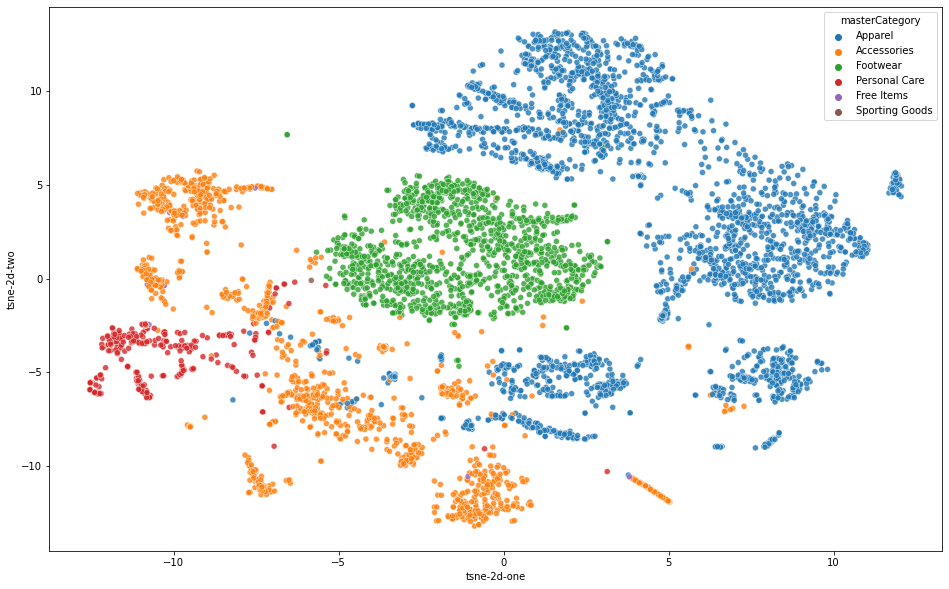

In [ ]:
plt.figure(figsize=(16,10))
sns.scatterplot(x="tsne-2d-one", y="tsne-2d-two",
                hue="masterCategory",
                data=df,
                legend="full",
                alpha=0.8)

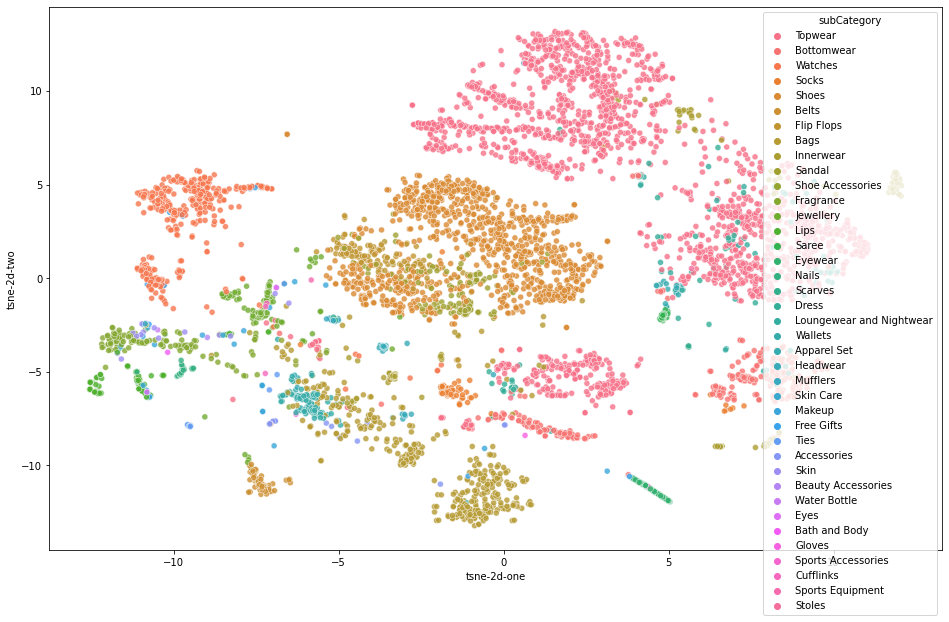

In [ ]:
plt.figure(figsize=(16,10))
sns.scatterplot(x="tsne-2d-one", y="tsne-2d-two",
                hue="subCategory",
                data=df,
                legend="full",
                alpha=0.8)

In [ ]:
tsne_results2 = tsne.fit_transform(df_embedding2)
print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

t-SNE done! Time elapsed: 212.43966484069824 seconds


In [ ]:
df['tsne-2d-one'] = tsne_results2[:,0]
df['tsne-2d-two'] = tsne_results2[:,1]

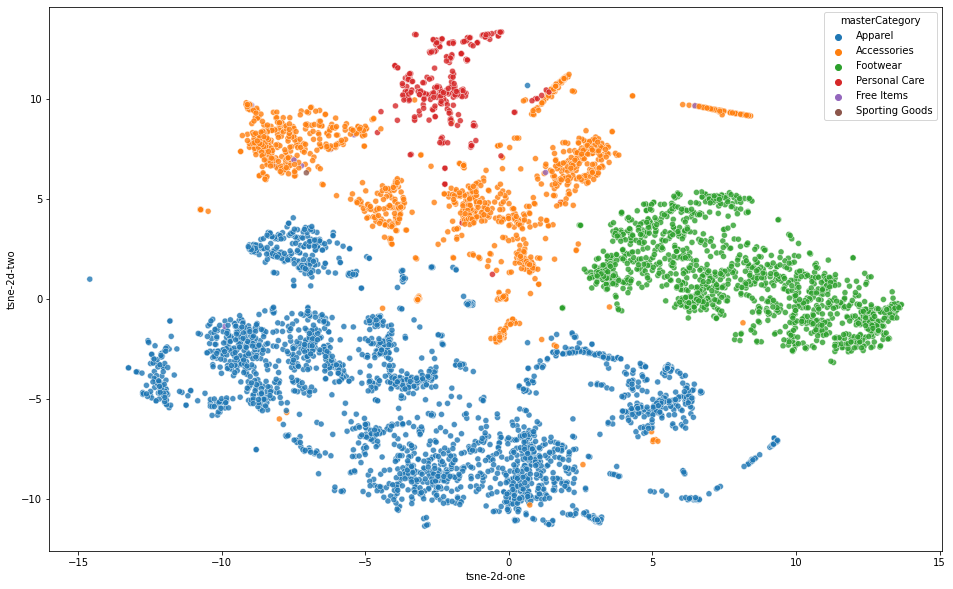

In [ ]:
plt.figure(figsize=(16,10))
sns.scatterplot(x="tsne-2d-one", y="tsne-2d-two",
                hue="masterCategory",
                data=df,
                legend="full",
                alpha=0.8)

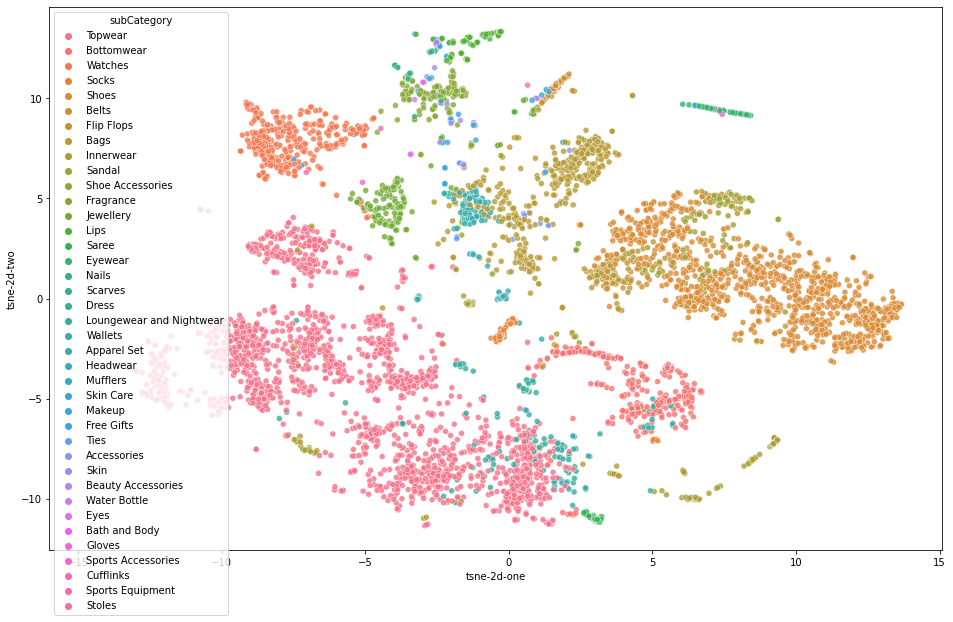

In [ ]:
plt.figure(figsize=(16,10))
sns.scatterplot(x="tsne-2d-one", y="tsne-2d-two",
                hue="subCategory",
                data=df,
                legend="full",
                alpha=0.8)

In [ ]:
tsne_results3 = tsne.fit_transform(df_embedding3)
print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

t-SNE done! Time elapsed: 521.542001247406 seconds


In [ ]:
df['tsne-2d-one'] = tsne_results3[:,0]
df['tsne-2d-two'] = tsne_results3[:,1]

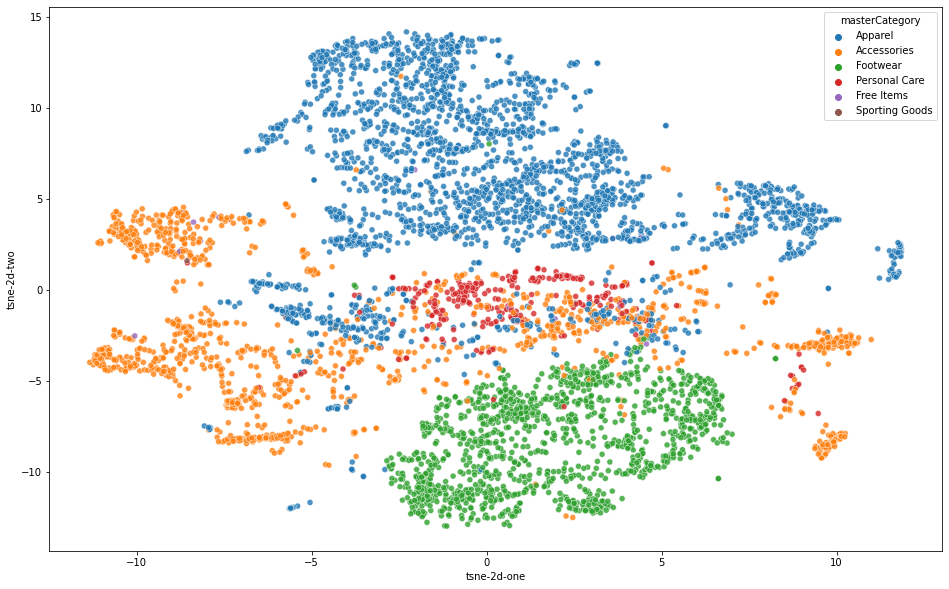

In [ ]:
plt.figure(figsize=(16,10))
sns.scatterplot(x="tsne-2d-one", y="tsne-2d-two",
                hue="masterCategory",
                data=df,
                legend="full",
                alpha=0.8)

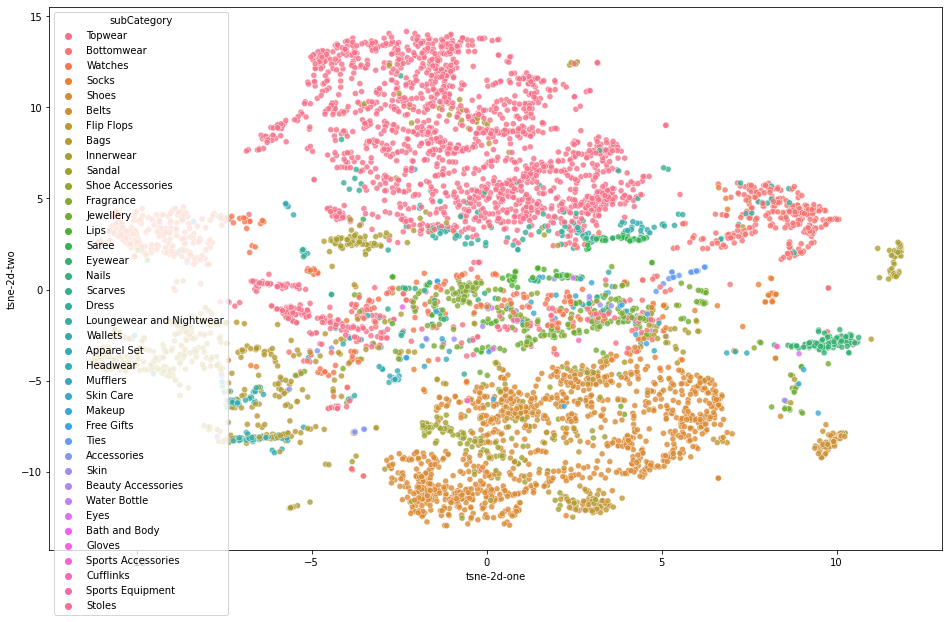

In [ ]:
plt.figure(figsize=(16,10))
sns.scatterplot(x="tsne-2d-one", y="tsne-2d-two",
                hue="subCategory",
                data=df,
                legend="full",
                alpha=0.8)

In [ ]:
df_embedding1.to_csv('embedding_vgg.csv')
df_embedding2.to_csv('embedding_dn.csv')
df_embedding3.to_csv('embedding_rn.csv')